# Actor Critic Method
**Original author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2020/05/13<br>
**Updated:** by Jordi, 2023/03/20<br>
Based on:
- https://github.com/keras-team/keras-io/blob/master/examples/rl/ipynb/actor_critic_cartpole.ipynb
- https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

### Actor Critic Method

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to two possible outputs:

1. Recommended action: A probability value for each action in the action space.
   The part of the agent responsible for this output is called the **actor**.
2. Estimated rewards in the future: Sum of all rewards it expects to receive in the
   future. The part of the agent responsible for this output is the **critic**.

Agent and Critic learn to perform their tasks, such that the recommended actions
from the actor maximize the rewards.

### CartPole-v1

A pole is attached to a cart placed on a frictionless track. The agent has to apply
force to move the cart. It is rewarded for every time step the pole remains upright.
The agent, therefore, must learn to keep the pole from falling over.

### References

- [CartPole](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)
- [CartPole OpenGym](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)
- [Actor Critic Method](https://hal.inria.fr/hal-00840470/document)

## Setup


In [1]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.mkdir("weights")

In [3]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters
seed = 42
env = gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True)
env.reset(seed=seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

## Implement Actor Critic network

This network learns two functions:

1. Actor: This takes as input the state of our environment and returns a
probability value for each action in its action space.
2. Critic: This takes as input the state of our environment and returns
an estimate of total rewards in the future.

They share the initial layer and are trained together.


In [4]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

def build_model(num_hidden=128):
    inputs = layers.Input(shape=(num_inputs,))
    common = layers.Dense(num_hidden, activation="relu")(inputs)
    action = layers.Dense(num_actions, activation="softmax")(common)
    critic = layers.Dense(1)(common)

    model = keras.Model(inputs=inputs, outputs=[action, critic])
    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            258         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            129         ['dense[0][0]']                  
                                                                                              

## Train
The training is done in several steps:
1. **Collect training data running one episode each time**
<br>Note here is that the next action is taken by sampling the action probabilities generated by the model (the line with `np.random.choice`).
2. **Compute expected returns**
<br>The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected in the previous step is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:
$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$
Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight. To stabilize training the resulting sequence of returns is standardized to have zero mean and unit standard deviation.
3. **Compute the loss function**
- The total loss is $L = L_{actor} + L_{critic}$.
- The **actor loss** function is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s):
$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$
where:
- $T$: the number of timesteps per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$
- The negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.
- The $G - V$ term in $L_{actor}$ is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.
- The **critic loss**: In this case the goal is to train the critic to output a value $V$ as close as possible as $G$ (as a regression problem). For that we can use the MSE, the MAE. A good option is to use the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data. Therefore we will use $L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$.


In [5]:
max_steps_per_episode = 10000
gamma = 0.99  # Discount factor for past rewards
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while running_reward < 195:  # Condition to consider the task solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        # Step 1: collect training data runnnig an episode
        for timestep in range(1, max_steps_per_episode):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, terminated, truncated, info = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if terminated or truncated:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Step 2: compute expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Step 3: calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:        
        print("Episode {:4d}, running reward: {:.2f}".format(episode_count, running_reward))

    # Save status in early stage
    if episode_count == 50:
        model.save_weights("weights/actor_critic_episode_%03d.h5" % episode_count)

print("Solved at episode", episode_count)
model.save_weights("weights/actor_critic_episode_%03d.h5" % episode_count)

Episode   10, running reward: 8.46
Episode   20, running reward: 10.10
Episode   30, running reward: 10.00
Episode   40, running reward: 10.76
Episode   50, running reward: 11.69
Episode   60, running reward: 11.37
Episode   70, running reward: 11.28
Episode   80, running reward: 11.68
Episode   90, running reward: 12.82
Episode  100, running reward: 13.12
Episode  110, running reward: 12.96
Episode  120, running reward: 12.40
Episode  130, running reward: 12.02
Episode  140, running reward: 12.79
Episode  150, running reward: 11.49
Episode  160, running reward: 11.40
Episode  170, running reward: 11.82
Episode  180, running reward: 13.69
Episode  190, running reward: 12.74
Episode  200, running reward: 12.30
Episode  210, running reward: 12.32
Episode  220, running reward: 11.85
Episode  230, running reward: 10.97
Episode  240, running reward: 10.37
Episode  250, running reward: 10.05
Episode  260, running reward: 10.05
Episode  270, running reward: 10.12
Episode  280, running reward:

In [6]:
# Play when fully trained
state = env.reset()
total_reward = 0
for episodes in range(300):
    state = model(state[None, ...])
    state = np.argmax(state[0])
    state, reward, terminated, truncated, info  = env.step(state)
    total_reward += reward
    if terminated or truncated:
        break

imgs = env.render()
print('Episodes', episodes+1, 'total reward', total_reward)

Episodes 300 total reward 300.0


In [7]:
from PIL import Image, ImageDraw, ImageFont
from IPython import display

def show_animation(imgs):
    font = ImageFont.truetype("LiberationMono-Regular.ttf", size=14)
    frames = [Image.fromarray(im) for im in imgs]
    for n, frame in enumerate(frames):
        draw = ImageDraw.Draw(frame)
        draw.text((10, 10), 'Frame %d' % (n+1), fill=(0, 0, 0), font=font)
    animation = frames[0]
    animation.save("animation.gif", format="GIF", append_images=frames, save_all=True, duration=100)  # duration in ms
    # display.Image('animation.gif')

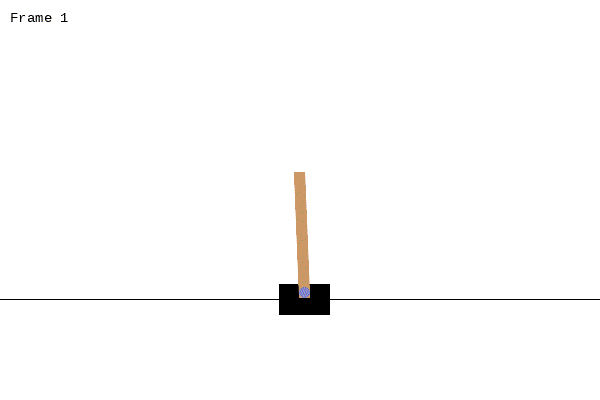

In [8]:
show_animation(imgs)
display.Image('animation.gif')

In [9]:
# Play at early states
model50 = build_model()
model50.load_weights("weights/actor_critic_episode_050.h5")

state = env.reset()
total_reward = 0
for episodes in range(300):
    state = model50(state[None, ...])
    state = np.argmax(state[0])
    state, reward, done, _, _  = env.step(state)
    total_reward += reward
    if done:
        break

imgs = env.render()
print('Episodes', episodes+1, 'total reward', total_reward)

Episodes 10 total reward 10.0


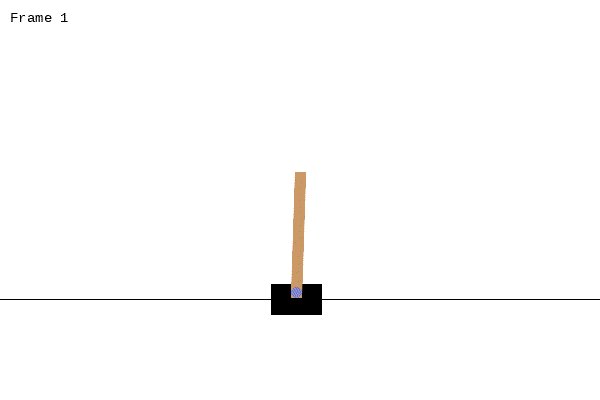

In [11]:
show_animation(imgs)
display.Image("animation.gif")

# Ejercicios

### Ejercicio 1: prueba a cambiar la función de coste de la red `critic`. Prueba MSE y MAE.

### Adapta el código para que funcione con el sistema [*Pendulum*](https://www.gymlibrary.dev/environments/classic_control/pendulum/).

In [ ]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

def build_model_new(num_hidden=128):
    inputs = layers.Input(shape=(num_inputs,))
    common = layers.Dense(num_hidden, activation="relu")(inputs)
    action = layers.Dense(num_actions, activation="softmax")(common)
    critic = layers.Dense(1, 'tanh')(common)

    model = keras.Model(inputs=inputs, outputs=[action, critic])
    return model

model = build_model_new()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 128)          640         ['input_3[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 2)            258         ['dense_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 1)            129         ['dense_6[0][0]']                
                                                                                            

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
max_steps_per_episode = 10000
gamma = 0.99  # Discount factor for past rewards
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

mae_history = []
mse_history = []

while running_reward < 195:  # Condition to consider the task solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        # Step 1: collect training data runnnig an episode
        for timestep in range(1, max_steps_per_episode):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, terminated, truncated, info = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if terminated or truncated:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Step 2: compute expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Step 3: calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # MAE and MSE
        actor_losses_stacked = tf.stack(actor_losses, axis=0)
        critic_losses_stacked = tf.stack(critic_losses, axis=0)
        
        mae = tf.reduce_mean(tf.abs(actor_losses_stacked))
        mse = tf.reduce_mean(tf.square(actor_losses_stacked))
        mae_history.append(mae.numpy())
        mse_history.append(mse.numpy())

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:        
        print("Episode {:4d}, running reward: {:.2f}".format(episode_count, running_reward))

    # Save status in early stage
    if episode_count == 50:
        model.save_weights("weights/actor_critic_episode_%03d.h5" % episode_count)

print("Solved at episode", episode_count)
model.save_weights("weights/actor_critic_episode_%03d.h5" % episode_count)

Episode   10, running reward: 11.36
Episode   20, running reward: 24.38
Episode   30, running reward: 23.79
Episode   40, running reward: 20.56
Episode   50, running reward: 18.80
Episode   60, running reward: 19.25
Episode   70, running reward: 18.66
Episode   80, running reward: 20.13
Episode   90, running reward: 32.08
Episode  100, running reward: 43.25
Episode  110, running reward: 50.59
Episode  120, running reward: 54.34
Episode  130, running reward: 50.54
Episode  140, running reward: 45.90
Episode  150, running reward: 46.55
Episode  160, running reward: 66.04
Episode  170, running reward: 78.32
Episode  180, running reward: 62.77
Episode  190, running reward: 72.07
Episode  200, running reward: 69.60
Episode  210, running reward: 74.49
Episode  220, running reward: 62.91
Episode  230, running reward: 52.19
Episode  240, running reward: 70.50
Episode  250, running reward: 161.24
Episode  260, running reward: 180.50
Episode  270, running reward: 133.95
Episode  280, running rew

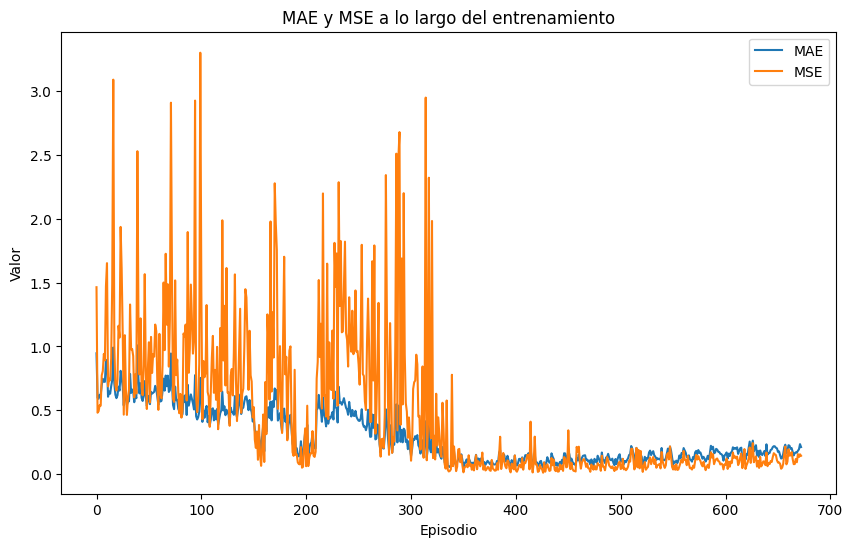

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mae_history, label='MAE')
plt.plot(mse_history, label='MSE')
plt.xlabel('Episodio')
plt.ylabel('Valor')
plt.legend()
plt.title('MAE y MSE a lo largo del entrenamiento')
plt.show()

El mismo método _actor_/_crítico_ está desarrollado para _Pendulum_ en la siguiente práctica.